In [46]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import csv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
# Загружаю датасет отзывов об aple
reviews = pd.read_csv('data_aple.csv',engine='python', on_bad_lines='skip')

In [48]:
#Смотрю состав датасета
reviews.head()

,Unnamed: 0,Review,Rating
0,0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,1,"Отключается при температуре близкой к нулю, не...",4
2,2,"В Apple окончательно решили не заморачиваться,...",3
3,3,Постарался наиболее ёмко и коротко описать все...,4
4,4,Достойный телефон. Пользоваться одно удовольст...,5


In [49]:
#Проверяю типы данных
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33463 entries, 0 to 33462
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  33463 non-null  int64 
 1   Review      33339 non-null  object
 2   Rating      33463 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 784.4+ KB


In [50]:
# Создаю функцию для присвоения метки по правилу : Rating = 5,4 - 1(положит); Rating 3,2,1 - 0(отрицат)
def assigning_label(score):
    if score >= 4:
        return int(1)
    else:
        return int(0)

In [51]:
# Присваиваю метки согласно столбца Rating
reviews['label'] = reviews['Rating'].apply(assigning_label)

In [52]:
#Проверяю измененный датасет
reviews.head()

,Unnamed: 0,Review,Rating,label
0,0,3D Touch просто восхитительная вещь! Заряд дер...,5,1
1,1,"Отключается при температуре близкой к нулю, не...",4,1
2,2,"В Apple окончательно решили не заморачиваться,...",3,0
3,3,Постарался наиболее ёмко и коротко описать все...,4,1
4,4,Достойный телефон. Пользоваться одно удовольст...,5,1


In [53]:
import matplotlib.pyplot as plt

<Axes: >

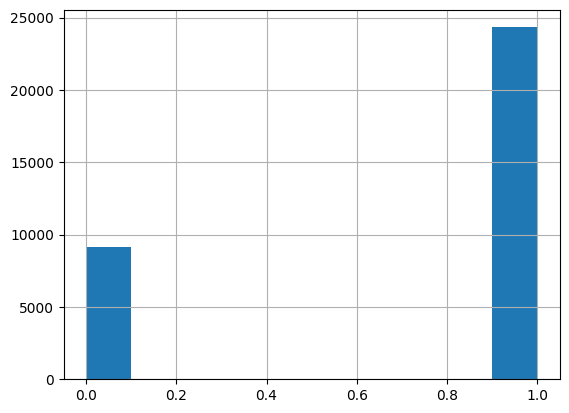

In [54]:
# Смотрю графически рапределение положительных и отрицательных отзывов
reviews['label'].hist()

In [55]:
# Произведу разметку датасета с активным обучением
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [56]:
# Перемешиваю данные
reviews = shuffle(reviews)

In [57]:
# Разделяю датасет на размеченную и неразмеченную части
labeled_reviews, unlabeled_reviews = train_test_split(reviews, train_size=0.2, random_state=52)

In [58]:
labeled_reviews.head()

,Unnamed: 0,Review,Rating,label
12578,12578,"Пользуюсь после айфона. Намного более удобный,...",3,0
32718,32718,Какой то нелепый получился аппарат зачем стави...,3,0
28782,28782,Покупали в подарок и прямо на вручили на празд...,1,0
16252,16252,Телефон идеален во всех отношениях. Дизайн сам...,5,1
19487,19487,"Удивлен что он нравится не только нам, гикам, ...",5,1


In [59]:
unlabeled_reviews.head()

,Unnamed: 0,Review,Rating,label
5248,5248,Подобрать для себя бюджетный тариф так и не см...,5,1
2931,2931,"Около года пользовался нормально(хотелось,прав...",5,1
28564,28564,"В целом, аппарат хороший. Зарядку держит день ...",4,1
6780,6780,Ребята накупившие китайских версий запомните г...,5,1
25554,25554,Я в восторге!!!,5,1


In [60]:
# Создаю функцию для обучения модели логистической регрессии на размеченных данных
def train_model(labeled_reviews):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(labeled_reviews['Review'].values.astype('U')) # .values.astype('U') - преобразуем объект в текст
    y = labeled_reviews['label']

    # Обучение модели логистической регрессии на размеченных данных
    model = LogisticRegression()
    model.fit(X, y)

    return model, vectorizer

In [61]:
# Обучаю начальную модель на малой части
model, vectorizer = train_model(labeled_reviews)

In [62]:
# Исходная модель для прогнозирования неразмеченных данных
X_unlabeled = vectorizer.transform(unlabeled_reviews['Review'].values.astype('U'))
y_unlabeled_predicted = model.predict(X_unlabeled)

In [63]:
# Вычисляю неопределенности или энтропии предсказаний
y_unlabeled_proba = model.predict_proba(X_unlabeled)
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

In [64]:
# Выбор 100 наиболее неопределенных точек данных для маркировки человеком
labeled_reviews_new = unlabeled_reviews.iloc[uncertainty.argsort()[:100]]
unlabeled_reviews_new = unlabeled_reviews.iloc[uncertainty.argsort()[100:]]

In [65]:
# Разметка новых точек данных и добавление их к размеченному множеству
labeled_reviews = pd.concat([labeled_reviews, labeled_reviews_new])

In [66]:
# Переобучение модели на расширенном маркированном множестве
model, vectorizer = train_model(labeled_reviews)

In [67]:
reviews_test = pd.read_csv('aple_test.csv', engine='python',encoding='utf-8', on_bad_lines='skip')

In [68]:
# Оценка модели на тестовом датасете
X_test = vectorizer.transform(reviews_test['Review'].values.astype('U'))
y_test_predicted = model.predict(X_test)
f1 = f1_score(reviews_test['label'], y_test_predicted)

print(f1)

0.8878628487479833
